Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Features Table

In [2]:
def extract_trial_date(filename):
    match = re.search(r"(\d{2}-\d{2}-\d{4})", filename)
    return match.group(1) if match else "Unknown"

def extract_animal_name(filename):
    return filename.split("_")[1]

def trials_type(df):
    trial_name_start = []
    trial_name_end = []
    for column in df.columns:
        if "Trial name" in column:
            if "started" in column:
                trial_name_start.append(column)
            elif "Finished" in column:
                trial_name_end.append(column)
    return trial_name_start, trial_name_end

base_folder_path = r"C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset"
day_folders = ["day 1", "day 2", "day 3", "day 4", "day 5"]

processed_folder = os.path.join(base_folder_path, "Features Table")
os.makedirs(processed_folder, exist_ok=True)

for day_name in day_folders:
    folder_path = os.path.join(base_folder_path, day_name)
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(f"Processing {day_name} ... found {len(csv_files)} files.")

    summary_data = []  # reset for each day

    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        animal_name = extract_animal_name(os.path.basename(csv_file))

        control_rate, bin1_rate, bin2_rate, bin3_rate, bin4_rate, bin5_rate, bin6_rate, bin7_rate, bin8_rate, bin9_rate, bin10_rate, prediction_rate, reward_rate = ([] for _ in range(13))

        trial_starts, trial_ends = trials_type(df)
        if not trial_starts or not trial_ends:
            continue

        start_col = trial_starts[0]
        end_col = trial_ends[0]

        for i in range(200):  # 200 trials per day
            start_trial = df.loc[i, start_col]
            end_trial = df.loc[i, end_col]

            if pd.isna(start_trial) or pd.isna(end_trial):
                continue

            reward_values = df.loc[(df['Dev1/port0/line7 S output'] > start_trial) &
                                   (df['Dev1/port0/line7 S output'] < end_trial), 'Dev1/port0/line7 S output']

            tone_values = df.loc[(df['Tone S output'] > start_trial) &
                                 (df['Tone S output'] < end_trial), 'Tone S output']

            if reward_values.empty or tone_values.empty:
                continue

            reward_onset = reward_values.iloc[0]
            tone_onset = tone_values.iloc[0]

            starting_point = tone_onset - 2.49
            controlbin = tone_onset - 2.24
            bin1 = tone_onset - 1.99
            bin2 = tone_onset - 1.74
            bin3 = tone_onset - 1.49
            bin4 = tone_onset - 1.24
            bin5 = tone_onset - 0.99
            bin6 = tone_onset - 0.74
            bin7 = tone_onset - 0.49
            bin8 = tone_onset - 0.24
            bin9 = tone_onset + 0.01
            predbin = reward_onset - 0.24
            rewardbin = reward_onset + 0.01
            finishbin = reward_onset + 0.26

            licking = df['Dev1/ai13 L input']
            control_rate.append(licking[(licking > starting_point) & (licking < controlbin)].count())
            bin1_rate.append(licking[(licking >= controlbin) & (licking < bin1)].count())
            bin2_rate.append(licking[(licking >= bin1) & (licking < bin2)].count())
            bin3_rate.append(licking[(licking >= bin2) & (licking < bin3)].count())
            bin4_rate.append(licking[(licking >= bin3) & (licking < bin4)].count())
            bin5_rate.append(licking[(licking >= bin4) & (licking < bin5)].count())
            bin6_rate.append(licking[(licking >= bin5) & (licking < bin6)].count())
            bin7_rate.append(licking[(licking >= bin6) & (licking < bin7)].count())
            bin8_rate.append(licking[(licking >= bin7) & (licking < bin8)].count())
            bin9_rate.append(licking[(licking >= bin8) & (licking < bin9)].count())
            bin10_rate.append(licking[(licking >= bin9) & (licking < predbin)].count())
            prediction_rate.append(licking[(licking >= predbin) & (licking < rewardbin)].count())
            reward_rate.append(licking[(licking >= rewardbin) & (licking < finishbin)].count())

        if bin1_rate:  # Only if data exists
            bin_means = [np.mean(b) for b in [control_rate, bin1_rate, bin2_rate, bin3_rate, bin4_rate, bin5_rate, bin6_rate, bin7_rate, bin8_rate, bin9_rate, bin10_rate, prediction_rate, reward_rate]]
            summary_data.append({
            'Animal': animal_name,
            'Control': bin_means[0],
            'Bin1': bin_means[1],
            'Bin2': bin_means[2],
            'Bin3': bin_means[3],
            'Bin4': bin_means[4],
            'Bin5': bin_means[5],
            'Bin6': bin_means[6],
            'Bin7': bin_means[7],
            'Bin8': bin_means[8],
            'Bin9': bin_means[9],
            'Bin10': bin_means[10],
            'Prediction': bin_means[11],
            'Reward': bin_means[12]
            })

    output_path = os.path.join(processed_folder, f"features_{day_name.replace(' ', '')}.csv")
    pd.DataFrame(summary_data).to_csv(output_path, index=False)
    print(f"Saved {output_path}")

Processing day 1 ... found 18 files.
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\Features Table\features_day1.csv
Processing day 2 ... found 18 files.
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\Features Table\features_day2.csv
Processing day 3 ... found 18 files.
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\Features Table\features_day3.csv
Processing day 4 ... found 18 files.
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\Features Table\features_day4.csv
Processing day 5 ... found 19 files.
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\Features Table\features_day5.csv


Import Features Table files

In [3]:
features_day1 = pd.read_csv(os.path.join(processed_folder, "features_day1.csv"))
features_day2 = pd.read_csv(os.path.join(processed_folder, "features_day2.csv"))
features_day3 = pd.read_csv(os.path.join(processed_folder, "features_day3.csv"))
features_day4 = pd.read_csv(os.path.join(processed_folder, "features_day4.csv"))
features_day5 = pd.read_csv(os.path.join(processed_folder, "features_day5.csv"))

# Principal Component Analysis (PCA) 

In [4]:
input_folder = r"C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\Features Table"
output_folder = r"C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\PCA_2D"
os.makedirs(output_folder, exist_ok=True)

features = ['Control', 'Bin1', 'Bin2', 'Bin3', 'Bin4', 'Bin5', 'Bin6', 'Bin7', 'Bin8', 'Bin9', 'Bin10', 'Prediction', 'Reward']

pca_day_dfs = {}
pca_list = []

for file in sorted(os.listdir(input_folder)):
    if not file.endswith(".csv"):
        continue

    base = os.path.splitext(file)[0]
    m = re.search(r'(\d)', base)  # finds first digit in filename
    day_label = f"Day{m.group(1)}" if m else base

    df = pd.read_csv(os.path.join(input_folder, file))

    if "Animal" not in df.columns:
        raise ValueError(f"'Animal' column not found in {file}")

    # Standardize per day
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    # PCA (2 components)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['Animal'] = df['Animal'].values
    pca_df['Day'] = day_label

    out_name = f"{day_label}_PCA.csv"
    out_path = os.path.join(output_folder, out_name)
    pca_df.to_csv(out_path, index=False)
    print(f"Saved {out_path}")

    pca_day_dfs[day_label] = pca_df
    pca_list.append(pca_df)

Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\PCA_2D\Day1_PCA.csv
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\PCA_2D\Day2_PCA.csv
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\PCA_2D\Day3_PCA.csv
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\PCA_2D\Day4_PCA.csv
Saved C:\Users\Dell\Desktop\Data Science Applications in Neuroscience\Dataset\PCA_2D\Day5_PCA.csv


Import PCA_2D files

In [5]:
pca_day1_df = pd.read_csv(os.path.join(output_folder, "Day1_PCA.csv"))
pca_day2_df = pd.read_csv(os.path.join(output_folder, "Day2_PCA.csv"))
pca_day3_df = pd.read_csv(os.path.join(output_folder, "Day3_PCA.csv"))
pca_day4_df = pd.read_csv(os.path.join(output_folder, "Day4_PCA.csv"))
pca_day5_df = pd.read_csv(os.path.join(output_folder, "Day5_PCA.csv"))

PCA Day1 -- Day5 Trajectory Visualization

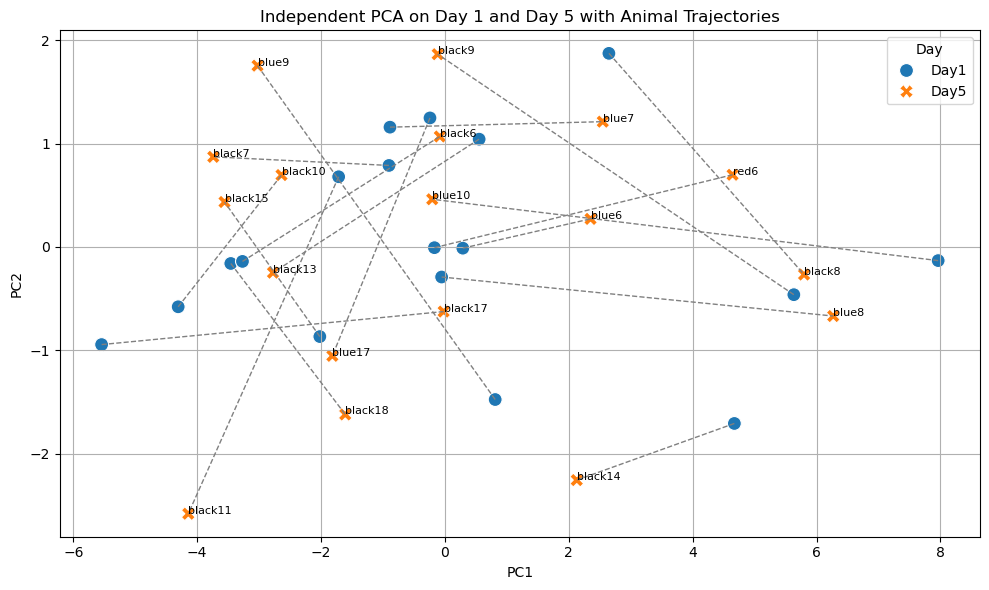

In [6]:
pca_combined = pd.concat([pca_day1_df, pca_day5_df], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=pca_combined,
    x='PC1', y='PC2',
    hue='Day', style='Day',
    s=100
)

animals = pca_combined['Animal'].unique()
for animal in animals:
    points = pca_combined[pca_combined['Animal'] == animal].sort_values('Day')
    if len(points) == 2:  # Ensure both days exist
        plt.plot(points['PC1'], points['PC2'], color='gray', linestyle='--', linewidth=1)
        plt.text(points['PC1'].iloc[1], points['PC2'].iloc[1], animal, fontsize=8)

plt.title("Independent PCA on Day 1 and Day 5 with Animal Trajectories")
plt.grid(True)
plt.tight_layout()
plt.show()

# K-means Clustering

In [8]:
# Create a dictionary
pca_days = {
    1: pca_day1_df,
    2: pca_day2_df,
    3: pca_day3_df,
    4: pca_day4_df,
    5: pca_day5_df
}

def cluster_day_pair(day_a, day_b, k=3):
    df_a = pca_days[day_a]
    df_b = pca_days[day_b]

    merged = pd.merge(df_a, df_b, on='Animal', suffixes=(f'_day{day_a}', f'_day{day_b}'))

    merged['delta_PC1'] = merged[f'PC1_day{day_b}'] - merged[f'PC1_day{day_a}']
    merged['delta_PC2'] = merged[f'PC2_day{day_b}'] - merged[f'PC2_day{day_a}']

    # K-means clsutering
    X_delta = merged[['delta_PC1', 'delta_PC2']]
    kmeans = KMeans(n_clusters=k, random_state=42)
    merged['Cluster'] = kmeans.fit_predict(X_delta)

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=merged, x='delta_PC1', y='delta_PC2', hue='Cluster', palette='Set2', s=100)
    
    # Annotate Animal IDs
    for i, row in merged.iterrows():
        plt.text(row['delta_PC1'] + 0.05, row['delta_PC2'], row['Animal'], fontsize=8)
    
    plt.title(f"Clustering Based on PCA Trajectory: Day {day_a} → Day {day_b}")
    plt.xlabel("Δ PC1")
    plt.ylabel("Δ PC2")
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return merged

Clustering Visualization based on PCA shifts from Day1 -- Day5

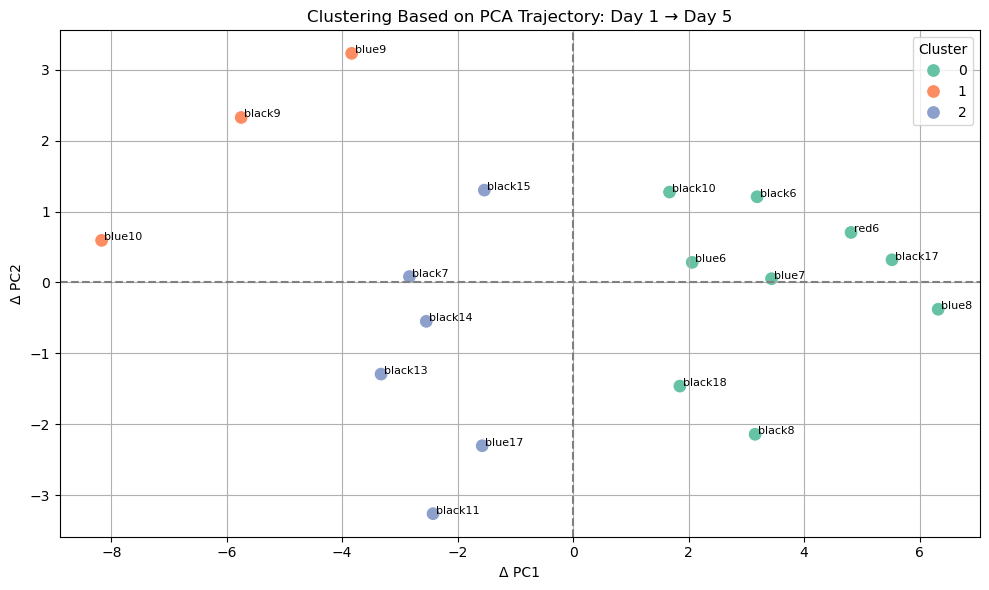

In [9]:
results_day1_5 = cluster_day_pair(1, 5)

# Learning Trajectory Analysis
(Based on Euclidean distance between Day1 and Day5)

     Animal  Euclidean_Distance
11   blue10            8.189274
15    blue8            6.332608
10   black9            6.202632
5   black17            5.530679
16    blue9            5.015021
17     red6            4.864304
1   black11            4.064110
9    black8            3.808520
2   black13            3.569690
14    blue7            3.435422
7    black6            3.406947
8    black7            2.837615
12   blue17            2.789333
3   black14            2.602707
6   black18            2.355456
0   black10            2.099206
13    blue6            2.081292
4   black15            2.015599


C:\Users\Dell\AppData\Local\Temp\ipykernel_18592\2812506924.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


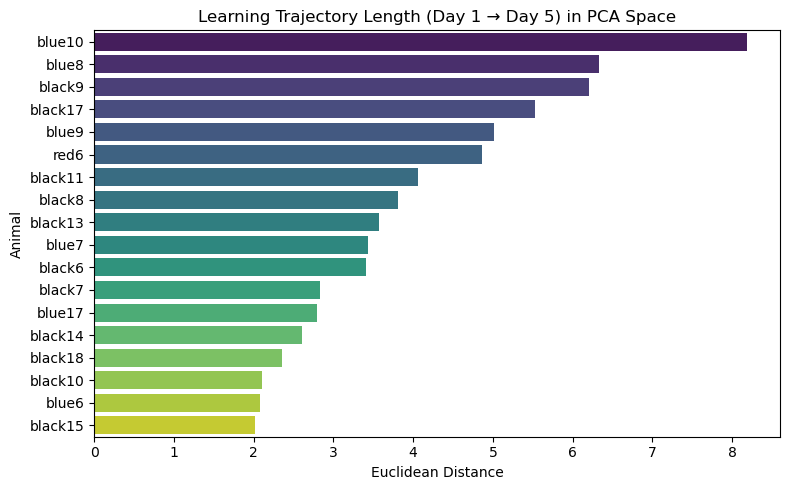

In [10]:
merged_1_5 = pd.merge(pca_day1_df, pca_day5_df, on='Animal', suffixes=('_day1', '_day5'))

# Compute Euclidean distance in PCA space
merged_1_5['Euclidean_Distance'] = np.sqrt(
    (merged_1_5['PC1_day5'] - merged_1_5['PC1_day1'])**2 +
    (merged_1_5['PC2_day5'] - merged_1_5['PC2_day1'])**2
)

# Sort by distance
merged_1_5 = merged_1_5.sort_values(by='Euclidean_Distance', ascending=False)
print(merged_1_5[['Animal', 'Euclidean_Distance']])

# Bar plot of distances
plt.figure(figsize=(8, 5))
sns.barplot(
    data=merged_1_5,
    x='Euclidean_Distance',
    y='Animal',
    palette='viridis'
)
plt.title("Learning Trajectory Length (Day 1 → Day 5) in PCA Space")
plt.xlabel("Euclidean Distance")
plt.ylabel("Animal")
plt.tight_layout()
plt.show()

# Classification Model

1. Identifying learning day (change of over 0.5 in rate between control and prediction bins)
2. Labeling according to the day there was learning (1/2 - fast, 3/4 - normal, 5 - slow)

In [11]:
feature_tables = [features_day1, features_day2, features_day3, features_day4, features_day5]

first_day_learned = {}

for day_index, features_day in enumerate(feature_tables, start=1):
    features_day["diff_pred_vs_control"] = features_day["Prediction"] - features_day["Control"]
    features_day["learning"] = features_day["diff_pred_vs_control"] > 0.5

    animals_learned = features_day.loc[features_day["learning"], "Animal"].tolist()

    for animal in animals_learned:
        if animal not in first_day_learned:
            first_day_learned[animal] = day_index

# Assign speed labels
learning_labels = {}
for animal, day in first_day_learned.items():
    if day in [1, 2]:
        learning_labels[animal] = "fast"
    elif day in [3, 4]:
        learning_labels[animal] = "normal"
    elif day == 5:
        learning_labels[animal] = "slow"

print("First learning day:", first_day_learned)
print("Learning speed labels:", learning_labels)

First learning day: {'black10': 2, 'black13': 2, 'black9': 2, 'blue10': 2, 'black14': 3, 'black15': 3, 'black6': 3, 'black8': 3, 'blue7': 3, 'blue9': 3, 'red6': 3, 'black11': 4, 'black18': 4, 'black7': 4, 'blue17': 4, 'blue6': 4, 'blue8': 4, 'black17': 5}
Learning speed labels: {'black10': 'fast', 'black13': 'fast', 'black9': 'fast', 'blue10': 'fast', 'black14': 'normal', 'black15': 'normal', 'black6': 'normal', 'black8': 'normal', 'blue7': 'normal', 'blue9': 'normal', 'red6': 'normal', 'black11': 'normal', 'black18': 'normal', 'black7': 'normal', 'blue17': 'normal', 'blue6': 'normal', 'blue8': 'normal', 'black17': 'slow'}


Random Forest Model

1. Prepare data

In [12]:
day1 = features_day1.copy()
day1["label"] = day1["Animal"].map(learning_labels)
day1 = day1.dropna(subset=["label"])  # keep only animals with labels

X = day1.drop(columns=["Animal", "label"])
y = day1["label"]

2. Random Forest Model with PCA
3. Cross Validation
4. Confusion Matrix

c:\Users\Dell\miniconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Random Forest Accuracy: 0.725 ± 0.075


c:\Users\Dell\miniconda3\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(


Random Forest Classification Report:
              precision    recall  f1-score   support

        fast       0.00      0.00      0.00         4
      normal       0.72      1.00      0.84        13
        slow       0.00      0.00      0.00         1

    accuracy                           0.72        18
   macro avg       0.24      0.33      0.28        18
weighted avg       0.52      0.72      0.61        18



c:\Users\Dell\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


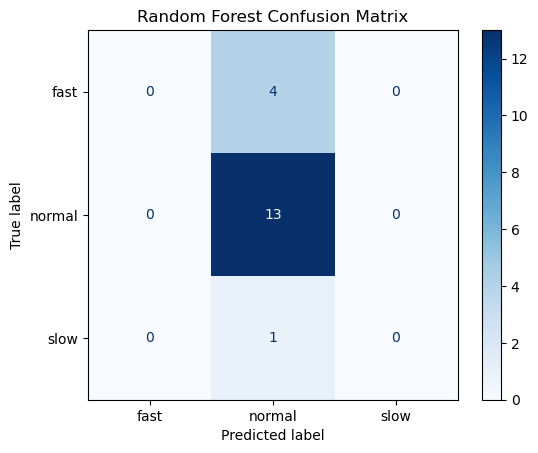

In [13]:
# Random Forest model with scaling + PCA
pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=4)),
    ("clf", RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42))
])

# Cross-validation setup
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Mean accuracy and std
scores_rf = cross_val_score(pipeline_rf, X, y, cv=cv, scoring='accuracy')
print(f"Random Forest Accuracy: {np.mean(scores_rf):.3f} ± {np.std(scores_rf):.3f}")

# Predictions for detailed metrics
y_pred_rf = cross_val_predict(pipeline_rf, X, y, cv=cv)
print("Random Forest Classification Report:")
print(classification_report(y, y_pred_rf))

# Confusion matrix for RF
cm_rf = confusion_matrix(y, y_pred_rf, labels=["fast", "normal", "slow"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["fast", "normal", "slow"])
disp_rf.plot(cmap="Blues", values_format='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

# Further Inspection
Feature Importance (before PCA)

C:\Users\Dell\AppData\Local\Temp\ipykernel_18592\2322742417.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=fi_df, palette="Blues_d")


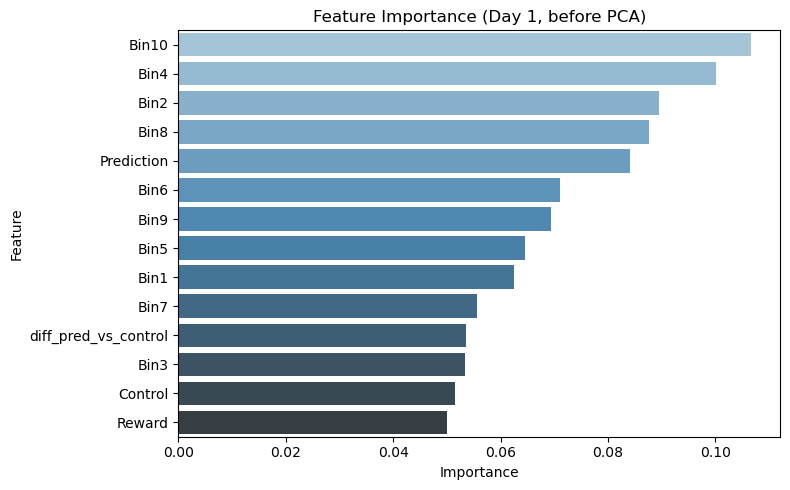

In [19]:
clf_fi = RandomForestClassifier(random_state=42, n_estimators=200)
clf_fi.fit(X, y)

importances = clf_fi.feature_importances_
feature_names = X.columns

# Sort features by importance
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

fi_df = fi_df[fi_df["Importance"] > 0].sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=fi_df, palette="Blues_d")
plt.title("Feature Importance (Day 1, before PCA)")
plt.tight_layout()
plt.show()